# Baseline CNN

在我们读入数据集中的图片时，我们需要对图片进行预处理，使其能够从图像转变为能够被模型读取的数据格式，同时对于训练数据，我们可能想对它们进行[数据增广](https://pytorch.org/vision/stable/transforms.html)来提升训练效果，这些操作都可以通过`torchvision.transforms`来实现。在下面，我们定义了一个针对了训练的`train_transform`，其中包含了数据转换与一些数据增广相关的变换，我们还定义了针对验证和测试的`test_transform`，其中只包含了数据转换的步骤，因为我们不需要在测试时进行数据增广。

In [2]:
from torchvision import transforms
import torch

# 下面的代码除了随机将图片裁剪为224x224以外的数据增广仅使用了随机擦除与水平翻转

train_transform = transforms.Compose(
    (
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        transforms.RandomResizedCrop(
            224, interpolation=transforms.InterpolationMode.BILINEAR
        ),
        transforms.RandomHorizontalFlip(),     
        transforms.RandomErasing(p=0.1),
    )
)

test_transform = transforms.Compose(
    (
        transforms.ToTensor(),
        transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(224),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    )
)

接下来我们需要定义数据集来读取数据，对于训练集和验证集，因为它们的文件结构为主文件夹中包含了对应多个类别的子文件夹。
所以我们可以直接使用`torchvision.datasets.ImageFolder`来建立带标签的数据集。但是对于测试集，我们需要通过继承`VisionDataset`类的方法来构建自己的数据集类。在这里，我们建立了`PlantDataset`，它能够读取指定文件夹下的所有图片，并且在被调用时返回经过转换后的数据值以及作为标签的文件名。
记得把你在上面定义的变换作为参数传给对应的数据集。

In [3]:
from torchvision.datasets import VisionDataset
from typing import Any, Callable, List, Optional, Tuple
from PIL import Image
from pathlib import Path
import re
import os


class PlantDataset(VisionDataset):
    def __init__(
        self,
        root: str,
        transforms: Optional[Callable] = None,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
    ) -> None:
        super().__init__(root, transforms, transform, target_transform)
        data_path = Path(self.root)
        image_list = list(data_path.glob("*.jpg"))
        self.images = [str(i) for i in image_list]

    def __getitem__(self, index: int) -> Any:
        image_path = self.images[index]
        image = Image.open(image_path).convert("RGB")
        image = self.transforms(image)

        label = re.sub(r"\D", "", os.path.sep(image_path)[1])  # 这里会把文件后缀给去掉，将文件名保留作为标签返回
        return image, int(label)

    def __len__(self) -> int:
        return len(self.images)

In [4]:
import os

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

data_path = './10 plants dataset'
batch_size = 32 # @param
num_workers = 0 # @param 如果你使用的是CPU，建议不要改动
torch.manual_seed(42) # @param 为你的pytorch指定一个随机数种子，使得每一次的结果可以被复现

train_path = (os.path.join(data_path, 'train'))
test_path = (os.path.join(data_path, 'test'))
val_path = (os.path.join(data_path, 'val'))

train_dataset = ImageFolder(
    train_path,
    train_transform)
val_dataset = ImageFolder(
    val_path,
    test_transform)
test_dataset = PlantDataset(
    test_path,
    test_transform)


在训练和测试时，PyTorch通过`DataLoader`类来从定义好的dataset中读取每一个batch的数据，在下面我们建立了三个`DataLoader`对象，并指定训练和验证时的batch size为超参数`batch_size`的值。此处我们还指定测试时的batch size为1，你也可以取一个其他值。

In [5]:
import torch
from torch import nn
from torch.nn import functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True)
val_loader = DataLoader(
    val_dataset,
    batch_size=len(val_dataset),
    num_workers=num_workers,
    shuffle=True)
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    num_workers=num_workers)

Using cpu device


在下面一个单元格中，请你搭建自己的神经网络。具体来说，你需要自定义一个继承自`nn.Module`的类，并在`__init__`方法中定义这个类各层的结构，在`forward`方法中定义网络前向传播的方式（反向传播已经由PyTorch替你安排好了，对此无需担心），如果你对这部分感到有问题，可以参阅PyTorch官方教程[BUILD THE NEURAL NETWORK](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)或询问助教。考虑到我们在处理的是二维图像问题，你可能还要参阅[二维卷积核(Conv2d)](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv2d)这一模块的文档，当然你也可以询问ChatGPT，请注意我们在`transforms`中指定图片的宽高为224x224，在计算卷积核大小时不要忘记这一点。
>注：你可以像官方教程一样将多个神经网络模块串联在`nn.Sequential()`中，也可以将它们分开定义，并在前向传播时指定传递方式，在搭建复杂的网络时往往后者更为实用。

In [6]:
from torch import nn

class ExampleNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = ExampleNetwork().to(device)
print(model)

ExampleNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


在下面，我们指定了模型训练的各超参数，我们默认使用带动量的SGD作为优化器，交叉熵损失作为损失函数，你也可以尝试使用Adam等不同的选择，或是指定学习率衰减策略。
我们还定义了一些用于评估模型训练效果的指标，如topk准确率，它们有助于我们在训练过程中跟踪模型的性能。

In [7]:
import numpy as np

learning_rate = 1e-3  # @param
epochs = 20  # @param
warmup_epoches = 2  # @param

iters_per_epoch = np.ceil(len(train_dataset) / batch_size)
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    model.parameters(), lr=learning_rate, weight_decay=1e-4, momentum=0.9
)

# scheduler = # 你可以选用一些学习率衰减策略

In [8]:
class AverageMeter(object):
  """Computes and stores the average and current value"""
  def __init__(self, name, fmt=':f'):
      self.name = name
      self.fmt = fmt
      self.reset()

  def reset(self):
      self.val = 0
      self.avg = 0
      self.sum = 0
      self.count = 0

  def update(self, val, n=1):
      self.val = val
      self.sum += val * n
      self.count += n
      self.avg = self.sum / self.count

  def __str__(self):
      fmtstr = '{name} {avg' + self.fmt + '}'
      return fmtstr.format(**self.__dict__)

def accuracy(output, target, topk=(1,)):
  """Computes the accuracy over the k top predictions for the specified values of k"""
  with torch.no_grad():
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

batch_time = AverageMeter('Time', ':6.3f')
data_time = AverageMeter('Data', ':6.3f')
losses = AverageMeter('Training loss', ':.4e')
top1 = AverageMeter('Acc@1', ':6.2f')
top5 = AverageMeter('Acc@5', ':6.2f')

以下是模型实际的训练代码，注意在每一次iteration中，loss在何时计算，梯度在何时反向传播（别忘记清空优化器中已有的梯度），权重和学习率（如果你有学习率衰减）在何时进行调整。每经过一个完整的epoch，模型会在验证集上进行一次评估，记录其损失和准确率。

In [9]:
import time

val_loss_history = []
loss_history = []
top1_history = []
top5_history = []
best_loss = 0x7fffffff

start = time.time()
for i in range(epochs):
  for batch, (X, y) in enumerate(train_loader):
    X = X.to(device)
    y = y.to(device)
    data_time.update(time.time() - start)
    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # scheduler.step()
  
  batch_time.update(time.time() - start)
  start = time.time()

  with torch.no_grad():
    for batch, (X, y) in enumerate(val_loader):
      X = X.to(device)
      y = y.to(device)
      pred = model(X)
      val_loss = loss_fn(pred, y)
      if val_loss.item() < best_loss:
        best_loss = val_loss.item()
        best_epoch = i
        best_model = model
      acc1, acc5 = accuracy(pred, y, topk=(1, 5))
      loss_history.append(loss.item())
      val_loss_history.append(val_loss.item())
      top1_history.append(acc1[0])
      top5_history.append(acc5[0])
      losses.update(loss.item(), X.size(0))
      top1.update(acc1[0], X.size(0))
      top5.update(acc5[0], X.size(0))
      
  print(f"Epoch:{i + 1}: {batch_time}, {losses}, Validation loss {val_loss.item():.4e}, {top1}, {top5}, learning rate {optimizer.state_dict()['param_groups'][0]['lr']}")
  losses.reset()
  top1.reset()
  top5.reset()

print(f"Best Epoch:{best_epoch + 1}, loss: {best_loss}, Acc@1: {top1_history[best_epoch]}, Acc@5: {top5_history[best_epoch]}")


/Users/nightingalecen/miniconda3/envs/tutor/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch:1: Time  8.906, Training loss 2.3134e+00, Validation loss 2.2884e+00, Acc@1  10.67, Acc@5  64.00, learning rate 0.001
Epoch:2: Time  9.002, Training loss 2.1963e+00, Validation loss 2.2597e+00, Acc@1  12.00, Acc@5  62.67, learning rate 0.001
Epoch:3: Time  9.033, Training loss 2.2433e+00, Validation loss 2.2168e+00, Acc@1  16.00, Acc@5  65.33, learning rate 0.001
Epoch:4: Time  9.007, Training loss 2.2516e+00, Validation loss 2.1543e+00, Acc@1  24.00, Acc@5  72.00, learning rate 0.001
Epoch:5: Time  9.002, Training loss 1.8603e+00, Validation loss 2.0807e+00, Acc@1  32.00, Acc@5  74.67, learning rate 0.001
Epoch:6: Time  9.067, Training loss 1.8893e+00, Validation loss 2.0261e+00, Acc@1  29.33, Acc@5  78.67, learning rate 0.001
Epoch:7: Time  9.071, Training loss 1.9439e+00, Validation loss 1.9611e+00, Acc@1  29.33, Acc@5  78.67, learning rate 0.001
Epoch:8: Time  9.087, Training loss 1.8073e+00, Validation loss 1.8999e+00, Acc@1  36.00, Acc@5  77.33, learning rate 0.001
Epoch:9:

训练结束之后，我们可以将每一个epoch存储的各项指标在图标上绘制出来，观察它们是怎样变化的。如果你使用tensorboard或wandb，这一过程也可以实时进行。注意执行这个单元格需要你安装了`matplotlib`库，你可以直接执行`pip install matplotlib`来安装（注意安装后可能需要你重启内核并重新训练）。

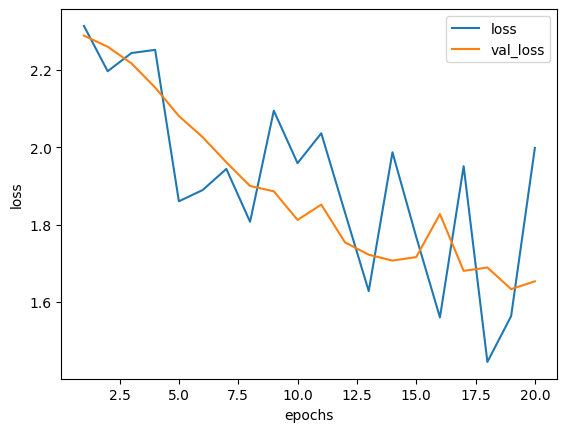

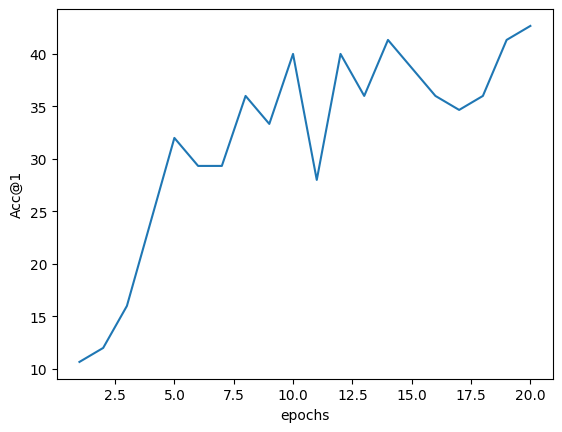

<Figure size 640x480 with 0 Axes>

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from torch import randint
%matplotlib inline
plt.plot(np.arange(1, epochs+1), loss_history, label="loss")
plt.plot(np.arange(1, epochs+1), val_loss_history, label="val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()
plt.clf()

plt.plot(np.arange(1, epochs+1), [i.item() for i in top1_history])
plt.xlabel("epochs")
plt.ylabel("Acc@1")
plt.show()
plt.clf()

通过将测试集的DataLoader传给下面的函数，我们可以对模型在测试集上进行测试，测试的过程与训练类似，只是不需要更新梯度。`model.eval()`和`with torch.no_grad():`会告诉模型现在正处于测试的状态，注意模型的输出总是一个代表了类别的整数，因此需要构建`IDX_TO_CLASSES`来建立反向的索引，使得我们能从模型输出的数字得到具体的类别名。

In [11]:
CLASSES_TO_IDX = train_dataset.class_to_idx
IDX_TO_CLASSES = {CLASSES_TO_IDX[i]:i for i in train_dataset.classes}


def test(model, test_image, name_prefix):
    model.eval()
    labels = []
    image_numbers = []
    with torch.no_grad(): # 在测试时，需要禁用梯度的计算
        for _, (images, image_number) in enumerate(test_image):
            images = images.to(device)
            y = model(images)
            batch_labels = torch.argmax(y, dim=1) # 取线性层输出最大值的下标作为我们对应的分类下标
            labels.append(batch_labels)
            image_numbers.append(image_number)
    ans = torch.cat(labels, 0).cpu().numpy()
    image_numbers = torch.cat(image_numbers, 0).cpu().numpy()
    res = {str(image_numbers[i]): IDX_TO_CLASSES[j] for i, j in enumerate(ans)}
    print(f"{name_prefix} model result:", res)
    return res


res = test(best_model, test_loader, "best")

/Users/nightingalecen/miniconda3/envs/tutor/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


best model result: {'63': 'Jasminum nudiflorum', '77': 'Ananas comosus', '76': 'Citrus reticulata', '62': 'Jasminum nudiflorum', '74': 'Ananas comosus', '60': 'Citrus reticulata', '48': 'Ananas comosus', '49': 'Ananas comosus', '61': 'Jasminum nudiflorum', '75': 'Ananas comosus', '59': 'Jasminum nudiflorum', '71': 'Ginkgo biloba', '65': 'Ginkgo biloba', '64': 'Jasminum nudiflorum', '70': 'Iris tectorum', '58': 'Jasminum nudiflorum', '8': 'Ananas comosus', '66': 'Ginkgo biloba', '72': 'Iris tectorum', '73': 'Citrus reticulata', '67': 'Ginkgo biloba', '9': 'Datura stramonium', '14': 'Ananas comosus', '28': 'Ginkgo biloba', '29': 'Ananas comosus', '15': 'Diospyros lotus', '17': 'Diospyros kaki', '16': 'Citrus reticulata', '12': 'Citrullus lanatus', '13': 'Citrus reticulata', '39': 'Citrus reticulata', '11': 'Ginkgo biloba', '10': 'Ananas comosus', '38': 'Ananas comosus', '21': 'Datura stramonium', '35': 'Citrus reticulata', '34': 'Citrus reticulata', '20': 'Jasminum nudiflorum', '36': 'An

接下来就可以输出你的模型测试结果了。

In [12]:
import json

with open("review/baseline_CNN.json", "w") as f:
    json.dump(res, f, indent=4)

{
    "63": "Jasminum nudiflorum",
    "77": "Ananas comosus",
    "76": "Citrus reticulata",
    "62": "Jasminum nudiflorum",
    "74": "Ananas comosus",
    "60": "Citrus reticulata",
    "48": "Ananas comosus",
    "49": "Ananas comosus",
    "61": "Jasminum nudiflorum",
    "75": "Ananas comosus",
    "59": "Jasminum nudiflorum",
    "71": "Ginkgo biloba",
    "65": "Ginkgo biloba",
    "64": "Jasminum nudiflorum",
    "70": "Iris tectorum",
    "58": "Jasminum nudiflorum",
    "8": "Ananas comosus",
    "66": "Ginkgo biloba",
    "72": "Iris tectorum",
    "73": "Citrus reticulata",
    "67": "Ginkgo biloba",
    "9": "Datura stramonium",
    "14": "Ananas comosus",
    "28": "Ginkgo biloba",
    "29": "Ananas comosus",
    "15": "Diospyros lotus",
    "17": "Diospyros kaki",
    "16": "Citrus reticulata",
    "12": "Citrullus lanatus",
    "13": "Citrus reticulata",
    "39": "Citrus reticulata",
    "11": "Ginkgo biloba",
    "10": "Ananas comosus",
    "38": "Ananas comosus",
 